In [1]:
import os
import sys
import glob
import pickle

import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
%matplotlib inline

# Calibrating the camera

In [3]:
def extract_calibration():
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('camera_cal/calibration*.jpg')
    size = len(images)
    # Step through the list and search for chessboard corners
    for i, fname in enumerate(images):
        # progress bar      
        sys.stdout.write('\r')
        percentage = 1. * (i + 1) / size
        progress = int(percentage * 20)
        bar_arg = [progress * '=', ' ' * (19 - progress), percentage * 100]
        bar_arg += [fname]
        sys.stdout.write('[{}>{}]{:.0f}%  {}'.format(*bar_arg))
        sys.stdout.flush()
        
        #Read image
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
    #         cv2.imshow('img',img)
    #         cv2.waitKey(500)

    # cv2.destroyAllWindows()
    return objpoints, imgpoints

In [4]:
obj_points, img_points = extract_calibration()

[====================>]100%  camera_cal/calibration9.jpg

In [5]:
def calibrate_cam(img, obj_points, img_points):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objectPoints = obj_points,
                                                       imagePoints = img_points,
                                                       imageSize = gray.shape[::-1],
                                                       cameraMatrix = None,
                                                       distCoeffs = None,
                                                      )
    return ret, mtx, dist, rvecs, tvecs

### Calibrate, calculate distortion coefficients, and test undistortion on an image!

In [6]:
img = mpimg.imread('test_images/test1.jpg')
ret, mtx, dist, rvecs, tvecs = calibrate_cam(img, obj_points, img_points)
undistorted_img = cv2.undistort(img, mtx, dist, None, mtx)

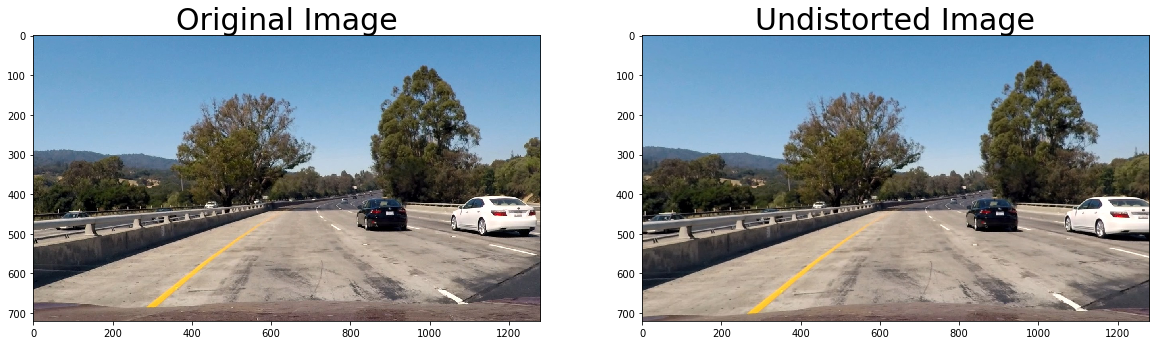

In [7]:
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undistorted_img)
ax2.set_title('Undistorted Image', fontsize=30)

In [8]:
# Save calibration Files
pickle.dump(mtx, open("mtx.p", "wb" ) )
pickle.dump(dist, open("dist.p", "wb" ) )

# Checkpoint

In [9]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Read in the saved camera matrix and distortion coefficients
# These are the arrays you calculated using cv2.calibrateCamera()
mtx = pickle.load( open("mtx.p", "rb" ) )
dist = pickle.load( open("dist.p", "rb" ) )

#Load and undistort test image
img = mpimg.imread('test_images/test1.jpg')
img = cv2.undistort(img, mtx, dist, None, mtx)

In [10]:
%matplotlib inline

# Trying different gradients

In [11]:
# Define a function that applies Sobel x or y, 
# then takes an absolute value and applies a threshold.
# Note: calling your function with orient='x', thresh_min=5, thresh_max=100
# should produce output like the example image shown above this quiz.
def abs_sobel_thresh(img, orient='x',  sobel_kernel = 3 ,thresh_min=0, thresh_max=255, ):
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled = np.uint8(255*(abs_sobel/abs_sobel.max()))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    mask = np.zeros_like(scaled)
    mask[(scaled>thresh_min)&(scaled<thresh_max)] = 1
    # 6) Return this mask as your binary_output image
    return mask

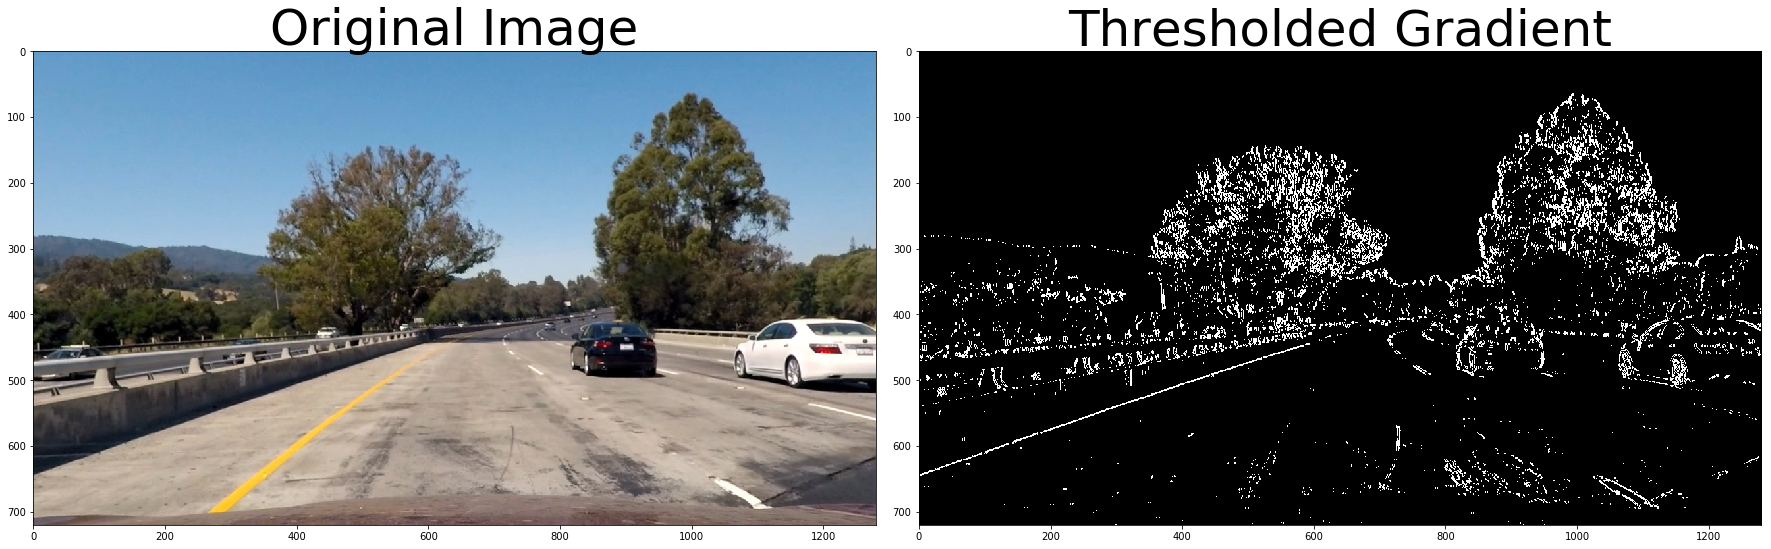

In [12]:
# Run the function
grad_binary = abs_sobel_thresh(img, orient='x', thresh_min=20, thresh_max=100)
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(grad_binary, cmap='gray')
ax2.set_title('Thresholded Gradient', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

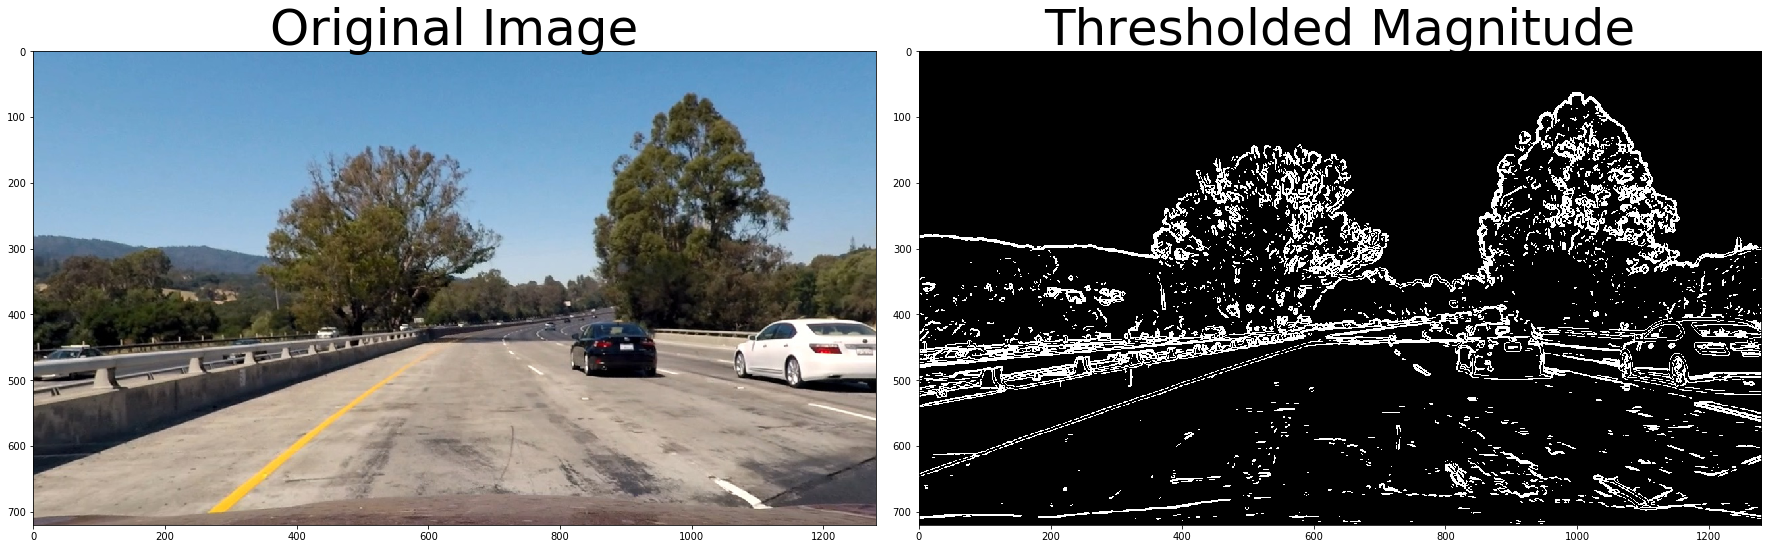

In [13]:
# Define a function that applies Sobel x and y, 
# then computes the magnitude of the gradient
# and applies a threshold
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    # 3) Calculate the magnitude 
    sobel = np.sqrt(sobelx**2 + sobely**2)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled = np.uint8(255*(sobel/sobel.max()))
    # 5) Create a binary mask where mag thresholds are met
    mask = np.zeros_like(scaled)
    mask[(scaled>mag_thresh[0])&(scaled<mag_thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return mask
    
# Run the function
mag_binary = mag_thresh(img, sobel_kernel=9, mag_thresh=(30, 100))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(mag_binary, cmap='gray')
ax2.set_title('Thresholded Magnitude', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

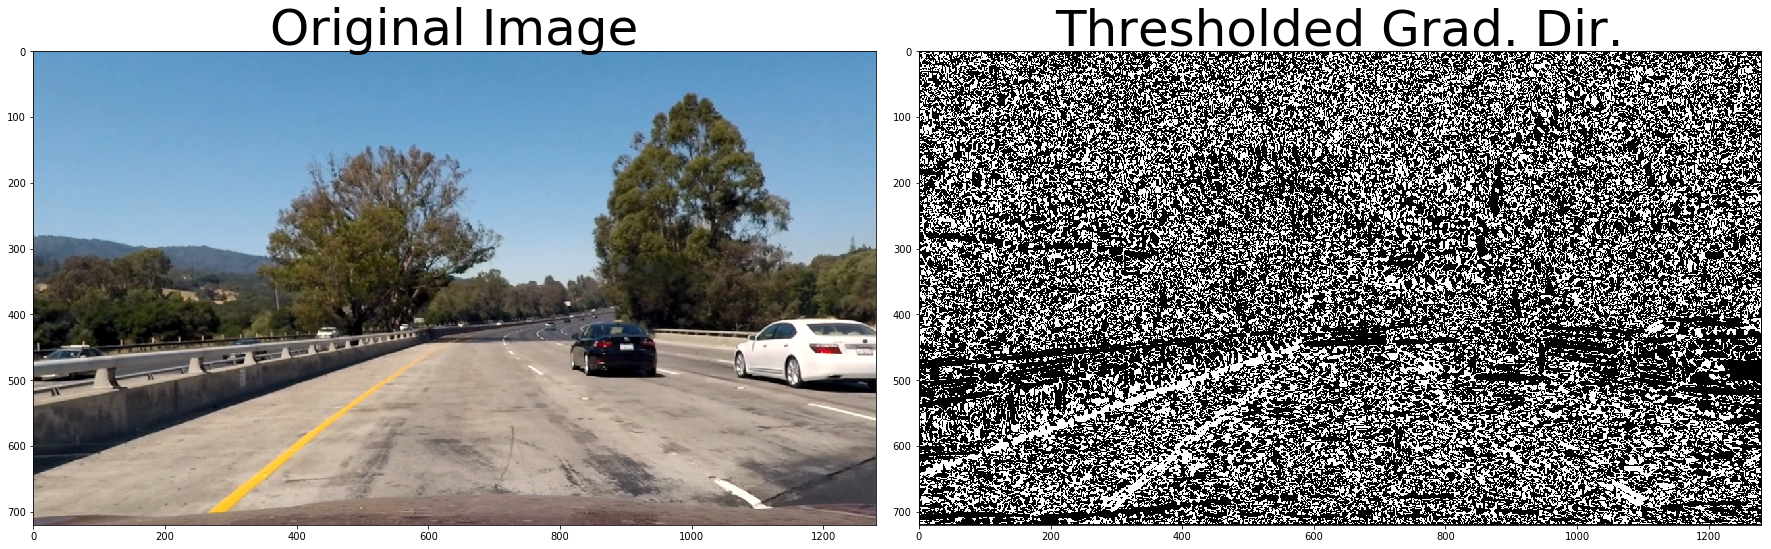

In [14]:
# Define a function that applies Sobel x and y, 
# then computes the direction of the gradient
# and applies a threshold.
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    sobel = np.arctan2(abs_sobely, abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    mask = np.zeros_like(sobel)
    mask[(sobel>thresh[0])&(sobel<thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return mask
    
# Run the function
dir_binary = dir_threshold(img, sobel_kernel=15, thresh=(0.7, 1.3))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(dir_binary, cmap='gray')
ax2.set_title('Thresholded Grad. Dir.', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Mix

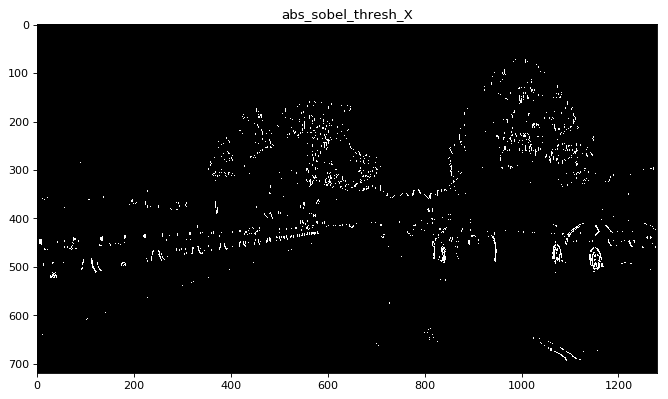

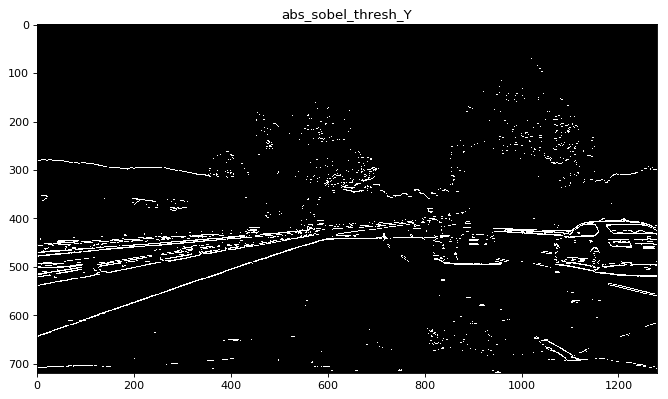

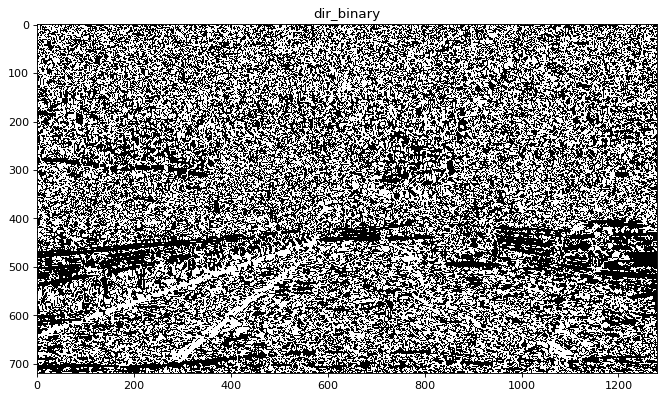

In [15]:
# Choose a Sobel kernel size
ksize = 3# Choose a larger odd number to smooth gradient measurements

# Apply and plot each of the thresholding functions
gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh_min=50, thresh_max=200)
plt.figure(num=None, figsize=(10, 10), dpi=80)
plt.imshow(gradx,'gray')
plt.title('abs_sobel_thresh_X')

grady = abs_sobel_thresh(img, orient='y', sobel_kernel=ksize, thresh_min=50, thresh_max=255)
plt.figure(num=None, figsize=(10, 10), dpi=80)
plt.imshow(grady,'gray')
plt.title('abs_sobel_thresh_Y')

dir_binary = dir_threshold(img, sobel_kernel=15, thresh=(0.5, 1.3))
plt.figure(num=None, figsize=(10, 10), dpi=80)
plt.imshow(dir_binary,'gray')
plt.title('dir_binary')

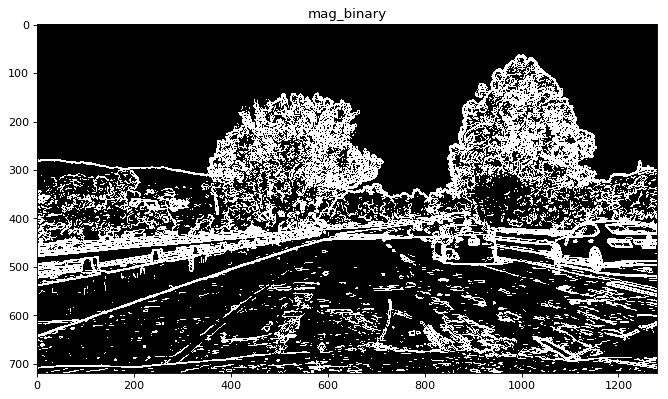

In [16]:
mag_binary = mag_thresh(img, sobel_kernel=5, mag_thresh=(15, 255))
plt.figure(num=None, figsize=(10, 10), dpi=80)
plt.imshow(mag_binary,'gray')
plt.title('mag_binary')

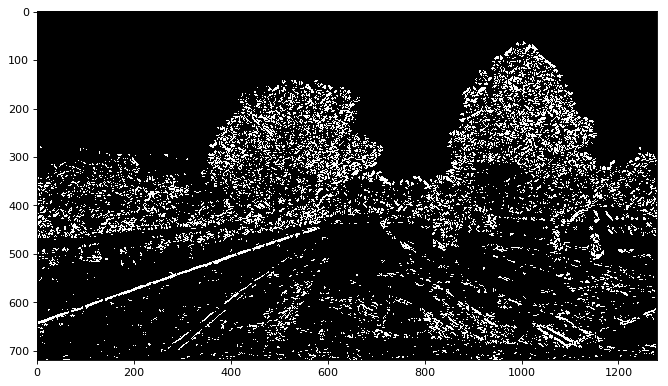

In [17]:
combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
plt.figure(num=None, figsize=(10, 10), dpi=80)
plt.imshow(combined,'gray')

In [18]:
dir_binary.shape

(720, 1280)

# HLS

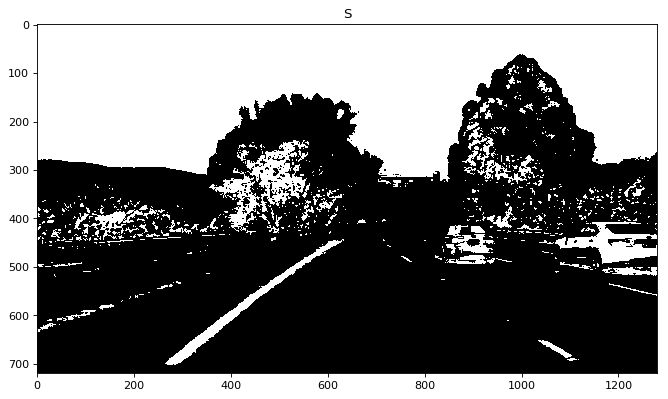

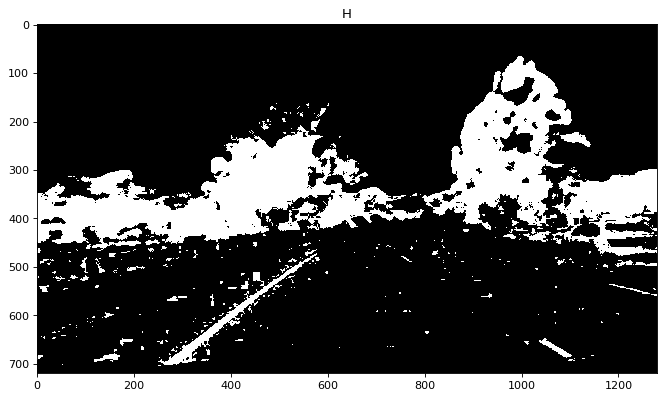

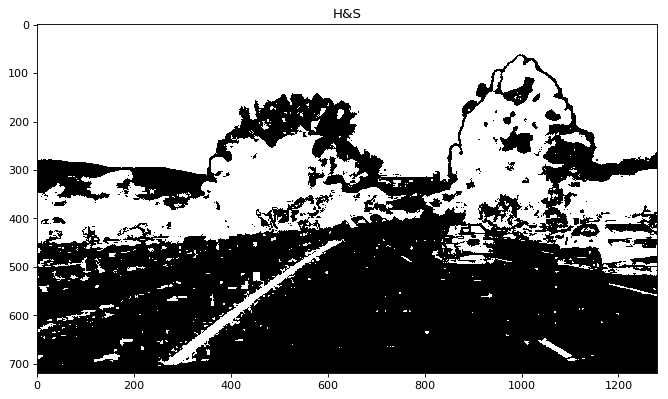

In [19]:
thresh = (180, 255)
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
binary = np.zeros_like(gray)
binary[(gray > thresh[0]) & (gray <= thresh[1])] = 1

# plt.figure(num=None, figsize=(10, 10), dpi=80)
# plt.imshow(binary,'gray')
# plt.title('GRAY')


hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
H = hls[:,:,0]
L = hls[:,:,1]
S = hls[:,:,2]

thresh = (90, 255)
binary_S = np.zeros_like(S)
binary_S[(S > thresh[0]) & (S <= thresh[1])] = 1
plt.figure(num=None, figsize=(10, 10), dpi=80)
plt.imshow(binary_S,'gray')
plt.title('S')

thresh = (17, 70)
binary_H = np.zeros_like(H)
binary_H[(H > thresh[0]) & (H <= thresh[1])] = 1

plt.figure(num=None, figsize=(10, 10), dpi=80)
plt.imshow(binary_H,'gray')
plt.title('H')

plt.figure(num=None, figsize=(10, 10), dpi=80)
plt.imshow(binary_H | binary_S,'gray')
plt.title('H&S')

# Combine S channel and mag_binary gradient

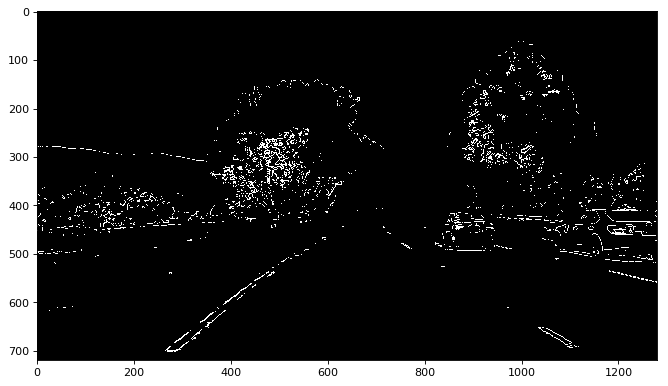

In [20]:
binary_image = np.zeros_like(dir_binary)
thresh = (90, 255)
binary_image[(mag_binary == 1) & ((S > thresh[0]) & (S <= thresh[1]))] = 1
plt.figure(num=None, figsize=(10, 10), dpi=80)
plt.imshow(binary_image,'gray')

# Final threshholding

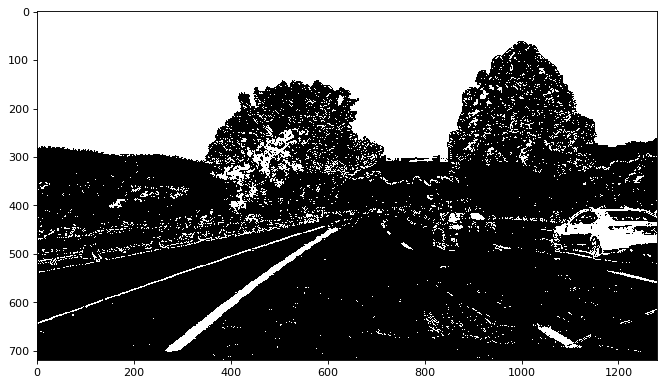

In [21]:
# Pick edges
gradx = abs_sobel_thresh(img, orient='x', thresh_min=12, thresh_max=255)
grady = abs_sobel_thresh(img, orient='y', thresh_min=25, thresh_max=255)

S = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)[:,:,2]
s_bin = np.zeros_like(img[:,:,0])
s_thresh = (100, 255)
s_bin[((S >= s_thresh[0]) & (S <= s_thresh[1]))] = 1

V = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)[:,:,2]
v_bin = np.zeros_like(img[:,:,0])
v_thresh = (50, 255)
v_bin[((V >= v_thresh[0]) & (V <= v_thresh[1]))] = 1

binary_image = np.zeros_like(img[:,:,0])
binary_image[((gradx == 1)&(grady == 1))|((s_bin == 1) & (v_bin == 1))] = 1
plt.figure(num=None, figsize=(10, 10), dpi=80)
plt.imshow(binary_image,'gray')

# Selecting the ROI (Region OF Interest)

In [22]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
    
    
    
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

In [23]:
imshape = binary_image.shape
vertices = np.array([[(imshape[1]*0.1,imshape[0]),
                      (imshape[1]*0.46, imshape[0]*0.62), # LEFT TOP
                      (imshape[1]*0.57, imshape[0]*0.62), # RIGHT TOP (W,H)
                      (imshape[1]*0.935,imshape[0])]], dtype=np.int32)

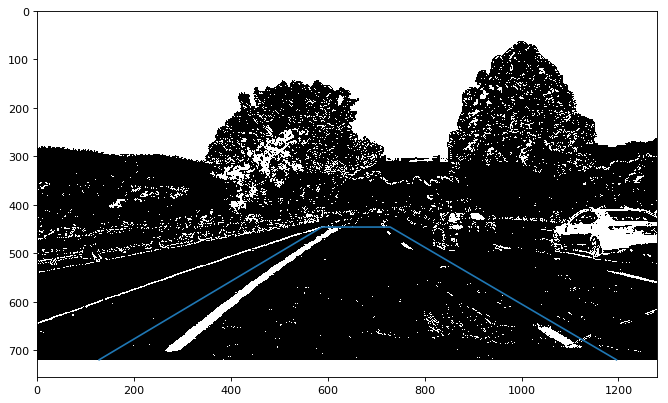

In [24]:
# Plot ROI
plt.figure(num=None, figsize=(10, 10), dpi=80)
plt.imshow(binary_image,'gray')
plt.plot(vertices[0,:,0],vertices[0,:,1])

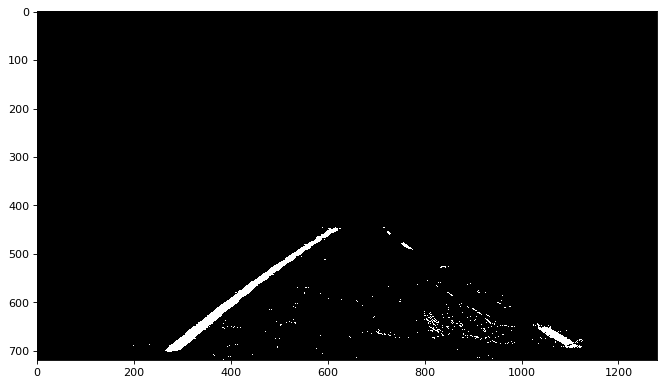

In [25]:
# CROP OUT ROI
binary_image_roi = region_of_interest(binary_image, vertices)
plt.figure(num=None, figsize=(10, 10), dpi=80)
plt.imshow(binary_image_roi,'gray')

In [26]:
vertices[0]

array([[ 128,  720],
       [ 588,  446],
       [ 729,  446],
       [1196,  720]], dtype=int32)

In [27]:
def warp_roi(img, src):
    imshape = (img.shape[1],img.shape[0])
    # Convert src to flaot
    src = np.float32(src)
    # Define destination coords
    dst = np.float32([[src[0,0],src[0,1]],
                      [src[0,0], 0],
                      [src[3,0], 0],
                      [src[3,0],src[3,1]]])

#     src = np.float32(
#     [[710,450],[1135,675],[110,675],[560,450]])
    
# #     #Four desired coordinates
#     dst = np.float32(
#     [[1135,20],[1135,675],[110,675],[110,20]])
    
    M = cv2.getPerspectiveTransform(src,dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, imshape, flags = cv2.INTER_LINEAR)
#     plt.figure(num=None, figsize=(10, 10), dpi=80)
#     plt.imshow(warped)
    return warped, M, Minv

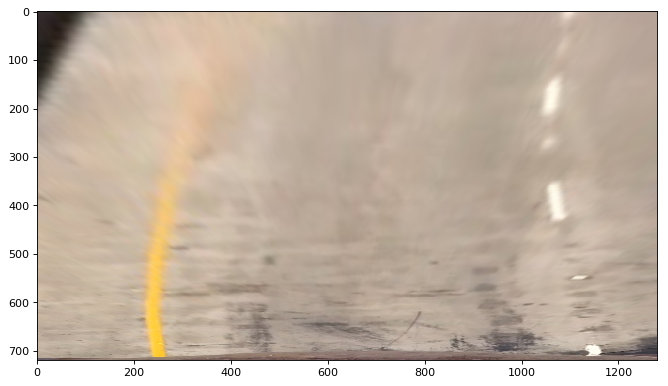

In [28]:
warped_img, _, _ = warp_roi(img, vertices[0])
plt.figure(num=None, figsize=(10, 10), dpi=80)
plt.imshow(warped_img)

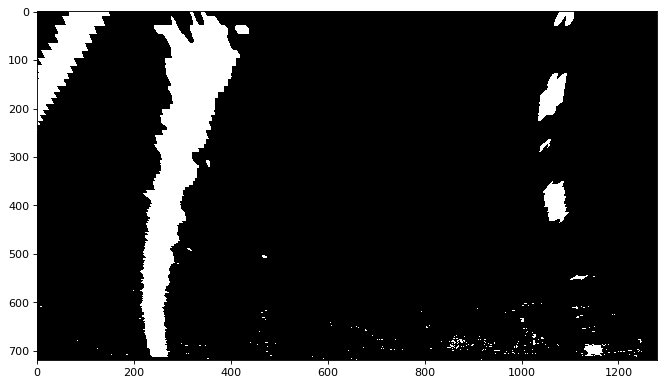

In [29]:
warped_binary, _, _ = warp_roi(binary_image, vertices[0])
plt.figure(num=None, figsize=(10, 10), dpi=80)
plt.imshow(warped_binary, 'gray')

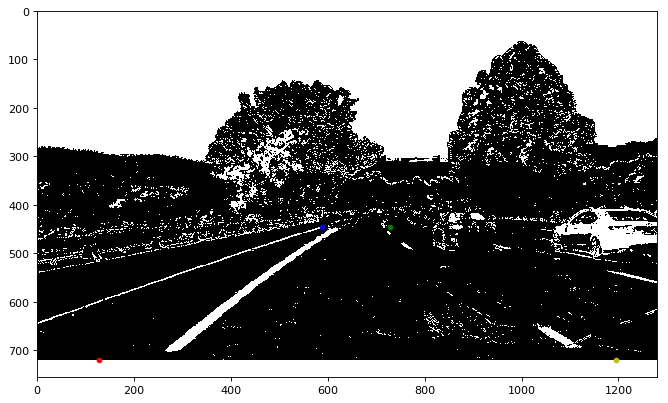

In [30]:
# Plot Source vertices
plt.figure(num=None, figsize=(10, 10), dpi=80)
plt.imshow(binary_image,'gray')
plt.plot(vertices[0,0,0],vertices[0,0,1],'ro',markersize=4)
plt.plot(vertices[0,1,0],vertices[0,1,1],'bo',markersize=4)
plt.plot(vertices[0,2,0],vertices[0,2,1],'go',markersize=4)
plt.plot(vertices[0,3,0],vertices[0,3,1],'yo',markersize=4)

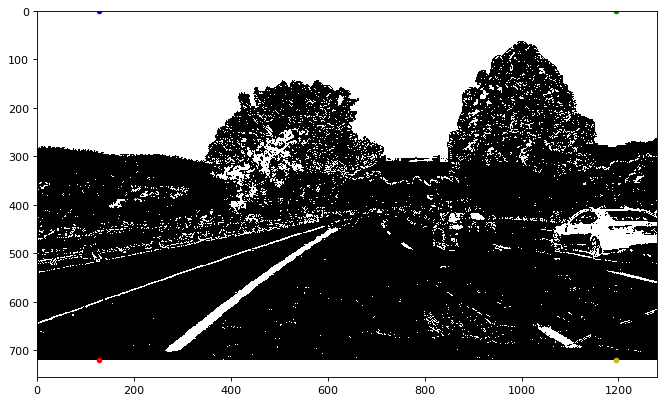

In [31]:
# Plot Destination vertices
imshape = img.shape[:2]
src = np.float32(vertices[0])
dst = np.float32([[src[0,0],src[0,1]],
                      [src[0,0], 0],
                      [src[3,0], 0],
                      [src[3,0],src[3,1]]])
plt.figure(num=None, figsize=(10, 10), dpi=80)
plt.imshow(binary_image,'gray')
plt.plot(dst[0,0],dst[0,1],'ro',markersize=4)
plt.plot(dst[1,0],dst[1,1],'bo',markersize=4)
plt.plot(dst[2,0],dst[2,1],'go',markersize=4)
plt.plot(dst[3,0],dst[3,1],'yo',markersize=4)

# Fitting the line

In [32]:
binary_warped = warped_binary

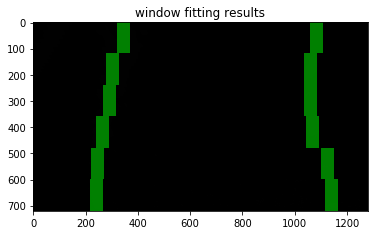

In [33]:
# window settings
window_width = 50 
window_height = 120 # Break image into 9 vertical layers since image height is 720
margin = 100 # How much to slide left and right for searching

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(warped, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(warped[int(3*warped.shape[0]/4):,:int(warped.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(warped[int(3*warped.shape[0]/4):,int(warped.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(warped.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(warped.shape[0]/window_height)):
	    # convolve the window into the vertical slice of the image
	    image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),:], axis=0)
	    conv_signal = np.convolve(window, image_layer)
	    # Find the best left centroid by using past left center as a reference
	    # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
	    offset = window_width/2
	    l_min_index = int(max(l_center+offset-margin,0))
	    l_max_index = int(min(l_center+offset+margin,warped.shape[1]))
	    l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
	    # Find the best right centroid by using past right center as a reference
	    r_min_index = int(max(r_center+offset-margin,0))
	    r_max_index = int(min(r_center+offset+margin,warped.shape[1]))
	    r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
	    # Add what we found for that layer
	    window_centroids.append((l_center,r_center))

    return window_centroids

window_centroids = find_window_centroids(binary_warped, window_width, window_height, margin)

# If we found any window centers
if len(window_centroids) > 0:

    # Points used to draw all the left and right windows
    l_points = np.zeros_like(binary_warped)
    r_points = np.zeros_like(binary_warped)

    # Go through each level and draw the windows 	
    for level in range(0,len(window_centroids)):
        # Window_mask is a function to draw window areas
	    l_mask = window_mask(window_width,window_height,binary_warped,window_centroids[level][0],level)
	    r_mask = window_mask(window_width,window_height,binary_warped,window_centroids[level][1],level)
	    # Add graphic points from window mask here to total pixels found 
	    l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
	    r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

    # Draw the results
    template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
    zero_channel = np.zeros_like(template) # create a zero color channle 
    template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
    warpage = np.array(cv2.merge((binary_warped,binary_warped,binary_warped)),np.uint8) # making the original road pixels 3 color channels
    output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results
 
# If no window centers found, just display orginal road image
else:
    output = np.array(cv2.merge((warped,warped,warped)),np.uint8)

# Display the final results
plt.imshow(output)
plt.title('window fitting results')
plt.show()


In [34]:
def hist_analysis(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
#     out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    return leftx, lefty, rightx, righty, left_fit, right_fit

In [35]:
leftx, lefty, rightx, righty, left_fit, right_fit = hist_analysis(binary_warped)

In [36]:
last_left_fitx = None
last_right_fitx = None

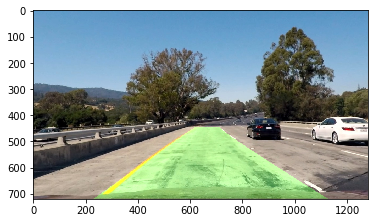

In [37]:
def draw_road_mask(img, binary_warped, left_fit, right_fit, use_n_frames = 3):
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    left_fitx = left_fitx.reshape(1,left_fitx.shape[0])
    right_fitx = right_fitx.reshape(1,right_fitx.shape[0])
#     print(np.concatenate([left_fitx,left_fitx]).shape)
#     print(right_fitx.shape)
    global last_left_fitx, last_right_fitx
    if last_left_fitx is None:
        last_left_fitx = left_fitx
    else:
        last_left_fitx = last_left_fitx[:use_n_frames,:]
        last_left_fitx = np.concatenate([left_fitx,last_left_fitx])
        left_fitx = last_left_fitx.mean(axis=0)
    
    if last_right_fitx is None:
        last_right_fitx = right_fitx
    else:
        last_right_fitx = last_right_fitx[:use_n_frames,:]
        last_right_fitx = np.concatenate([right_fitx,last_right_fitx])
        right_fitx = last_right_fitx.mean(axis=0)

    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    Minv = cv2.getPerspectiveTransform(dst, src)
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    return result
result = draw_road_mask(img, binary_warped, left_fit, right_fit)
plt.imshow(result)

In [38]:
def plot_metrics(img, warped, leftx,lefty,rightx,righty):
    y = np.linspace(0, img.shape[0], num=img.shape[0])# to cover same y-range as image

    left_fit = np.polyfit(lefty, leftx, 2)
    left_fitx = left_fit[0]*y**2 + left_fit[1]*y + left_fit[2]
    right_fit = np.polyfit(righty, rightx, 2)
    right_fitx = right_fit[0]*y**2 + right_fit[1]*y + right_fit[2]

    ## Find lane radius of curvature (m) ---------
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension 
    xm_per_pix = 3.7/700 # meters per pixel in x dimension 

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    y_eval = np.max(y)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
#     print(left_curverad, 'm', right_curverad, 'm')
    # Example values: 632.1 m    626.2 m    
    cv2.putText(img,'Radius of curvature: '  + str(left_curverad)[:6] + ' m',(20,40), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2)
    ## Find center position ----------
    left_mean = np.mean(leftx)
    right_mean = np.mean(rightx)
    center = warped.shape[1]/2 - np.mean([left_mean, right_mean])

    cv2.putText(img,'Center: '  + str(center*xm_per_pix)[:6] + ' m',(20,80), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2 )
#     print('Center: '  + str(center*xm_per_pix)[:6] + ' m')

# Putting all together

In [39]:
old_params = None
def pipeline(img):
    #Load and undistort test image
    img = cv2.undistort(img, mtx, dist, None, mtx)
    # Pick edges
    gradx = abs_sobel_thresh(img, orient='x', thresh_min=12, thresh_max=255)
    grady = abs_sobel_thresh(img, orient='y', thresh_min=25, thresh_max=255)
    
    S = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)[:,:,2]
    s_bin = np.zeros_like(img[:,:,0])
    s_thresh = (100, 255)
    s_bin[((S >= s_thresh[0]) & (S <= s_thresh[1]))] = 1
    
    V = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)[:,:,2]
    v_bin = np.zeros_like(img[:,:,0])
    v_thresh = (50, 255)
    v_bin[((V >= v_thresh[0]) & (V <= v_thresh[1]))] = 1
    
    binary_image = np.zeros_like(img[:,:,0])
    binary_image[((gradx == 1)&(grady == 1))|((s_bin == 1) & (v_bin == 1))] = 1
    
    binary_image_roi = region_of_interest(binary_image, vertices)
    
    binary_warped, M, Minv = warp_roi(binary_image_roi, vertices[0])
    
    global old_params
    try:
        leftx, lefty, rightx, righty, left_fit, right_fit = hist_analysis(binary_warped)
        old_params = [leftx, lefty, rightx, righty, left_fit, right_fit]
    except:
        leftx, lefty, rightx, righty, left_fit, right_fit = old_params
    
    plot_metrics(img, binary_warped,  leftx, lefty, rightx, righty)
    
    result = draw_road_mask(img, binary_warped, left_fit, right_fit)
    
    return result

In [40]:
img = mpimg.imread('test_images/test1.jpg')

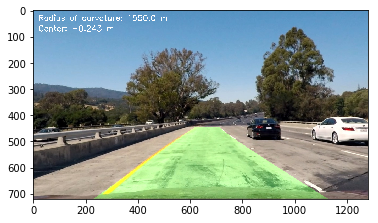

In [41]:
plt.imshow(pipeline(img))

In [42]:
ls

LineFinder.ipynb     example_writeup.pdf* mtx.p
README.md*           examples/            test_images/
camera_cal/          input_video/
dist.p               misc/


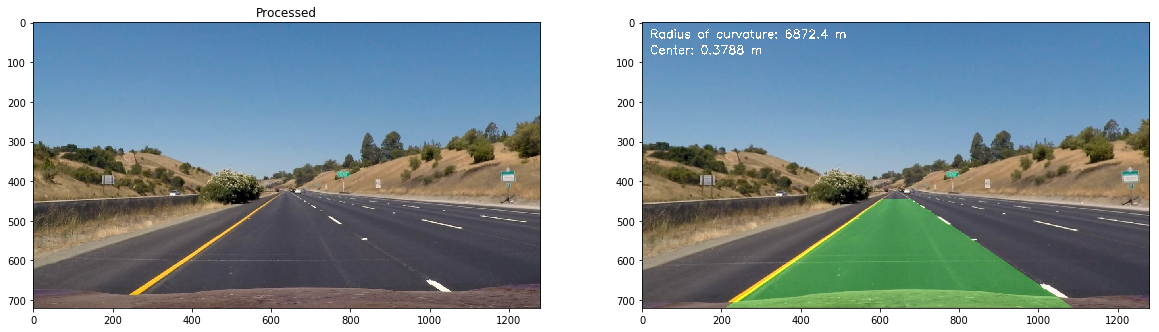

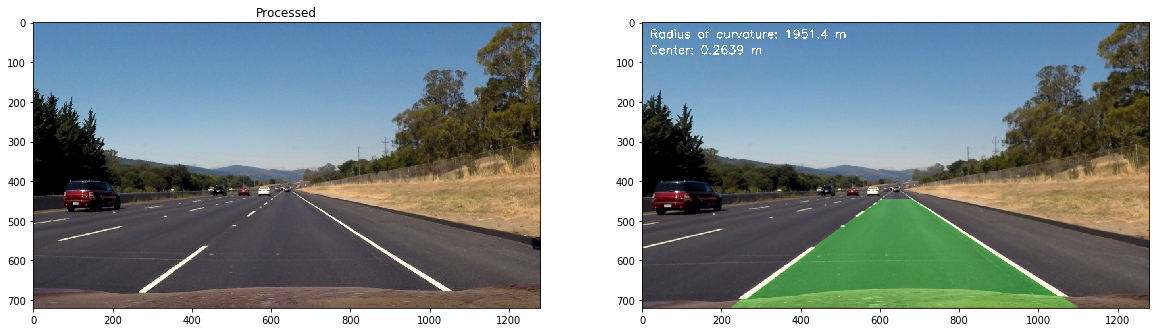

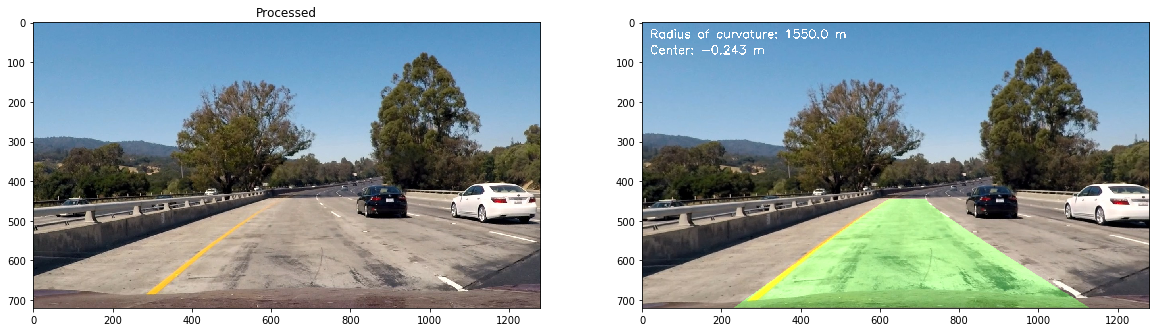

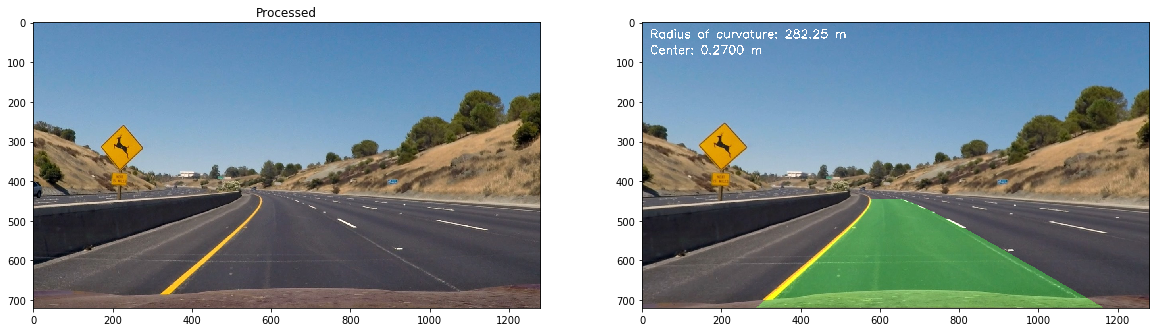

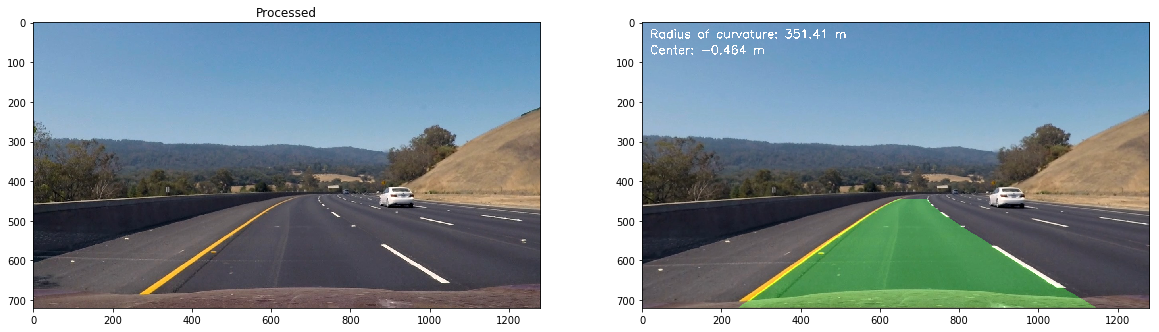

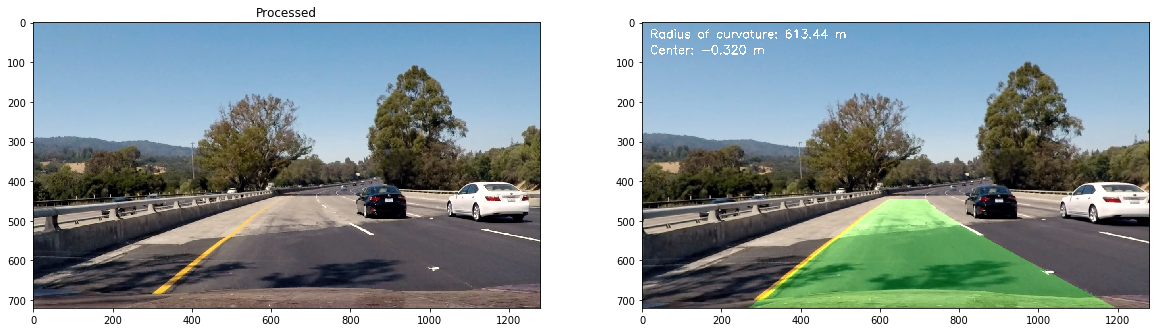

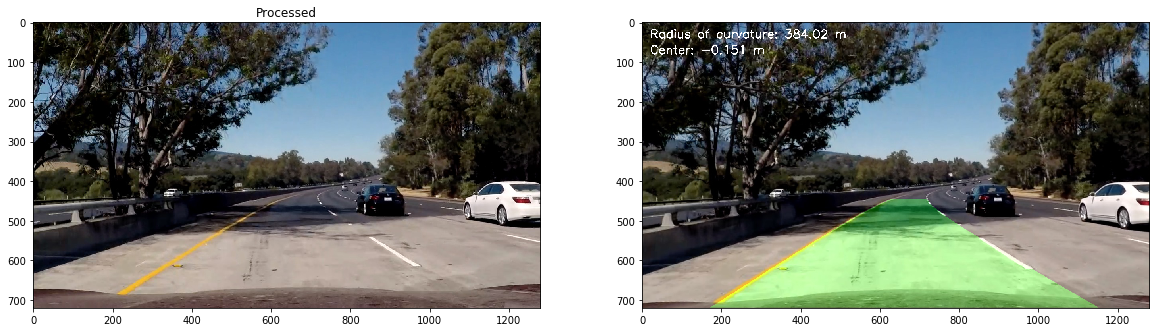

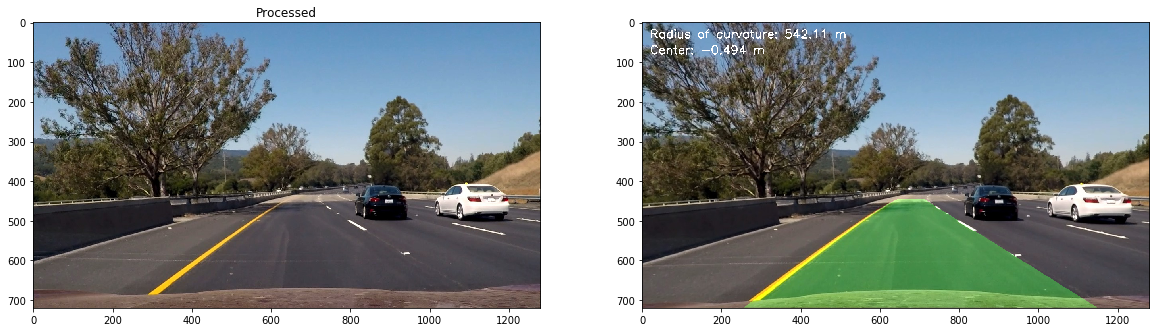

In [44]:
# Test full pipeline rendering
import glob

for fname in glob.glob('test_images/*.jpg'):
    last_left_fitx = None
    last_right_fitx = None
    old_params = None
    img = mpimg.imread(fname)
    pipeline(img)
    result = pipeline(img)

    # Two subplots, unpack the axes array immediately
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    ax1.set_title('Original')
    ax1.imshow(img)
    ax1.set_title('Processed')
    ax2.imshow(result)
    cv2.imwrite('misc/' + fname.split('/')[-1], result[:,:,[2,1,0]])

# Process video

In [45]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

last_left_fitx = None
last_right_fitx = None
old_params = None

write_output = 'misc/project_video_out.mp4'
clip1 = VideoFileClip("input_video/project_video.mp4")
write_clip = clip1.fl_image(pipeline) 
%time write_clip.write_videofile(write_output, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████▉| 1260/1261 [03:05<00:00,  7.15it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

CPU times: user 3min 50s, sys: 50 s, total: 4min 40s
Wall time: 3min 6s


In [43]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

last_left_fitx = None
last_right_fitx = None
old_params = None

write_output = 'misc/challenge_video_out.mp4'
clip1 = VideoFileClip("input_video/challenge_video.mp4")
write_clip = clip1.fl_image(pipeline)
%time write_clip.write_videofile(write_output, audio=False)

[MoviePy] >>>> Building video misc/challenge_video_out.mp4
[MoviePy] Writing video misc/challenge_video_out.mp4


100%|██████████| 485/485 [01:05<00:00,  7.78it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: misc/challenge_video_out.mp4 

CPU times: user 1min 24s, sys: 17.4 s, total: 1min 41s
Wall time: 1min 6s


# DISCUSSION

1. Briefly discuss any problems / issues you faced in your implementation of this project. Where will your pipeline likely fail? What could you do to make it more robust?

For given videos and images pipeline show quite good performance. 

Potential problems could be:
* Different road line marking (different coutries/regions)
* Absence of road line marking (if erased/old, outside city road)
* Invisibility of the lines due to snow/sand.
* and this:
![image](https://i.ytimg.com/vi/WVUgvVFb37k/hqdefault.jpg)

**How to overcome these:**
* Tune the parameters on the scenes with different light/weather conditions (night/snow)
* Train NN to produce mask of the road, then we can use that to predict the possible route/line can is at (that would work for case when there is no lane lines at all) 
